# Imports

In [3]:
import pandas as pd
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# !pip install datasets -q
# !pip install evaluate -q
# !pip install transformers[torch] -q
# !pip install accelerate -U

from datasets import load_dataset
import evaluate

In [3]:
import transformers
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Notebook Parameters

In [ ]:
# Specify paths to cleaned train and test data
TRAIN_PATH = "/content/drive/MyDrive/heavy_train_df_user_id_400.csv"
TEST_PATH = "/content/drive/MyDrive/heavy_test_df_user_id_400.csv"

In [ ]:
# Specify preprocessing scheme: "light" (for BERT) or "heavy" (stop word removal + lemmatization)
PREPROCESSING_SCHEME = "light"

In [ ]:
# Specify desired model from HuggingFace (https://huggingface.co/models)
MODEL = 'distilbert-base-uncased'

# Load Data

In [5]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

((2776772, 3), (744832, 3))

In [6]:
df_train.head()

,user_id,tweet_text,has_disorder
0,1401346400,miss moment tire face loudly cry face smile fa...,False
1,1401346400,cute smile face heart eye smile face heart eye,False
2,1401346400,day year one direction moment year one directi...,False
3,1401346400,wey pa cuando el video de infinity plead face ...,False
4,1401346400,love background smile face heart eye smile fac...,False


In [7]:
df_train = df_train.dropna()
df_test = df_test.dropna()

((2776768, 3), (744830, 3))

In [9]:
# Group based on user ID then concatenate all user tweets into one body of text per user
df_train = df_train.groupby('user_id').agg({'tweet_text': lambda x: ' '.join(x.tolist()), 'has_disorder': 'unique'})
df_train['has_disorder'] = df_train['has_disorder'].apply(lambda x: x[0])

df_test = df_test.groupby('user_id').agg({'tweet_text': lambda x: ' '.join(x.tolist()), 'has_disorder': 'unique'})
df_test['has_disorder'] = df_test['has_disorder'].apply(lambda x: x[0])

In [12]:
# Preprocessing required by HuggingFace
df_train = df_train[['tweet_text', 'has_disorder']].dropna()
df_train = df_train.rename(columns={"tweet_text": "text", "has_disorder": "label"})
df_train.loc[df_train['label'] == True, 'label'] = 1
df_train.loc[df_train['label'] == False, 'label'] = 0
df_train = df_train[df_train['text'].str.len() > 3]
df_train = df_train[['label', 'text']]
df_train = df_train.reset_index(drop=True)
df_train.to_csv(f"/content/drive/MyDrive/{PREPROCESSING_SCHEME}_df_train_400_grouped.csv", index = False)

df_test = df_test[['tweet_text', 'has_disorder']].dropna()
df_test = df_test.rename(columns={"tweet_text": "text", "has_disorder": "label"})
df_test.loc[df_test['label'] == True, 'label'] = 1
df_test.loc[df_test['label'] == False, 'label'] = 0
df_test = df_test[df_test['text'].str.len() > 3]
df_test = df_test[['label', 'text']]
df_test = df_test.reset_index(drop=True)
df_test.to_csv(f"/content/drive/MyDrive/{PREPROCESSING_SCHEME}_df_test_400_grouped.csv", index = False)

In [13]:
dataset = load_dataset('csv', data_files={'train': f"/content/drive/MyDrive/{PREPROCESSING_SCHEME}_df_train_400_grouped.csv",
                                          'test':  f"/content/drive/MyDrive/{PREPROCESSING_SCHEME}_df_test_400_grouped.csv"})
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 320
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 80
    })
})

# Load Model

In [15]:
# Load the ALBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# # default to left padding
# tokenizer.padding_side = "left"
# # Define PAD Token = EOS Token = 50256
# tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [17]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
tokenized_sample = preprocess_function(dataset['train'][0])
print(tokenized_sample)
print(f"Length of tokenized IDs: {len(tokenized_sample.input_ids)}")
print(f"Length of attention mask: {len(tokenized_sample.attention_mask)}")

{'input_ids': [101, 1048, 5339, 3232, 2095, 2144, 3235, 10474, 3335, 3124, 2681, 3492, 6429, 4180, 2369, 4415, 2175, 2342, 2066, 2111, 24185, 2155, 2175, 5647, 2291, 2113, 4919, 2504, 2331, 9826, 3087, 15221, 3477, 3086, 3294, 4474, 9202, 3398, 2067, 4952, 2113, 2197, 2095, 6594, 14398, 2518, 2111, 2633, 5630, 2116, 2317, 2710, 2066, 2821, 2175, 4095, 6659, 2710, 3239, 4066, 2028, 3114, 2710, 2178, 2051, 2317, 5154, 2202, 2835, 4952, 3046, 2425, 1057, 2287, 5621, 2919, 4933, 4148, 2145, 4148, 2433, 6517, 2202, 3558, 3464, 2775, 6289, 2518, 1057, 2963, 2172, 6289, 4365, 2434, 3010, 3124, 6643, 3726, 2126, 20524, 23969, 1039, 10974, 2243, 3582, 16827, 12849, 2618, 10671, 2192, 5396, 2422, 3096, 4309, 2812, 3835, 4717, 6174, 2831, 7213, 2131, 2247, 2092, 2131, 15095, 6687, 2175, 2793, 3422, 6108, 5917, 2208, 20101, 4952, 6108, 7408, 4647, 3335, 18454, 12624, 5407, 12824, 5917, 2694, 2136, 2066, 6865, 3748, 3358, 2022, 7606, 2063, 3189, 3961, 2995, 7539, 2173, 4281, 6123, 2562, 3198, 2606,

In [20]:
accuracy = evaluate.load("accuracy")

In [32]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [33]:
id2label = {0: "None", 1: "Depressed"}
label2id = {"Depressed": 1, "None": 0}

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, id2label=id2label, label2id=label2id)
# # resize model embedding to match new tokenizer
# model.resize_token_embeddings(len(tokenizer))

# # fix model padding token id
# model.config.pad_token_id = model.config.eos_token_id
# model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
pd.Series(dataset['train']['label']).value_counts()

1    160
0    160
Name: count, dtype: int64

# Train Model

In [50]:
# LIGHT
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results_light_400_grouped_distilbert_testing_3",
    learning_rate=8e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to = 'tensorboard',
    logging_steps = 10,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.696900,0.659633,0.712500
2,0.617700,0.584303,0.637500
3,0.511100,0.561714,0.712500
4,0.341200,0.628709,0.662500
5,0.237200,0.617619,0.725000


TrainOutput(global_step=50, training_loss=0.4808334159851074, metrics={'train_runtime': 38.4254, 'train_samples_per_second': 41.639, 'train_steps_per_second': 1.301, 'total_flos': 211947837849600.0, 'train_loss': 0.4808334159851074, 'epoch': 5.0})

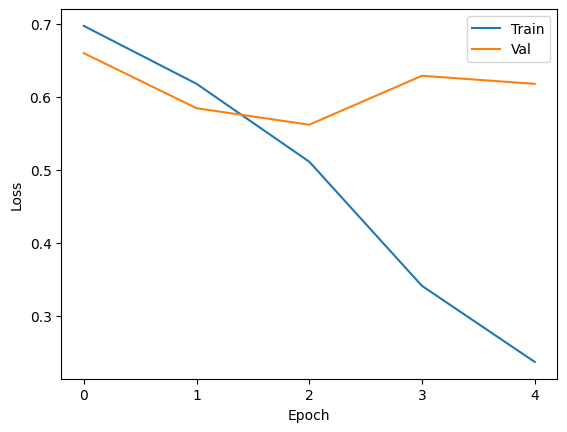

In [63]:
training_losses = [0.696900, 0.617700, 0.511100, 0.341200, 0.237200]
val_losses = [0.659633, 0.584303, 0.561714, 0.628709, 0.617619]
plt.plot(training_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xticks(np.arange(0, 5, 1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [37]:
# HEAVY
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results_heavy_400_grouped_distilbert_testing_3",
    learning_rate=8e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to = 'tensorboard',
    logging_steps = 10
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697600,0.687830,0.500000
2,0.659200,0.646958,0.587500
3,0.557200,0.648040,0.650000
4,0.418300,0.655745,0.675000
5,0.334500,0.639196,0.687500


TrainOutput(global_step=50, training_loss=0.5333715391159057, metrics={'train_runtime': 40.0824, 'train_samples_per_second': 39.918, 'train_steps_per_second': 1.247, 'total_flos': 211947837849600.0, 'train_loss': 0.5333715391159057, 'epoch': 5.0})

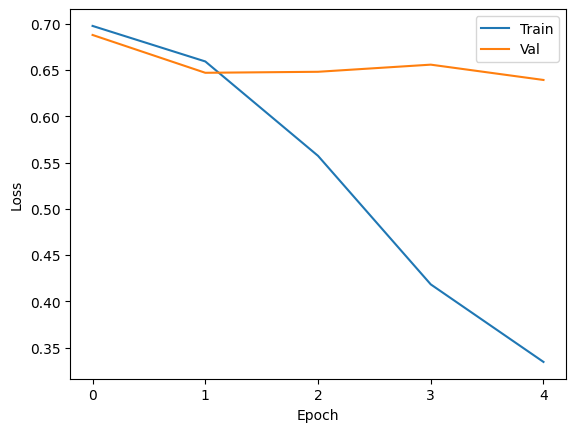

In [41]:
training_losses = [0.697600, 0.659200, 0.557200, 0.418300, 0.334500]
val_losses = [0.687830, 0.646958, 0.648040, 0.655745, 0.639196]
plt.plot(training_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xticks(np.arange(0, 5, 1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Model Evaluation

In [1]:
model = AutoModelForSequenceClassification.from_pretrained(
    f"/content/drive/MyDrive/results_{PREPROCESSING_SCHEME}_400_grouped_distilbert_testing_3/checkpoint-50"
).to(device)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
preds = trainer.predict(tokenized_dataset["test"])

NameError: name 'AutoModelForSequenceClassification' is not defined

In [53]:
y_preds, y_trues = [], []
for pred, label in zip(preds.predictions, preds.label_ids):
  y_pred = np.argmax(pred)
  y_true = label
  y_preds.append(y_pred)
  y_trues.append(y_true)

Text(0.5, 1.0, 'Accuracy: 72.50%')

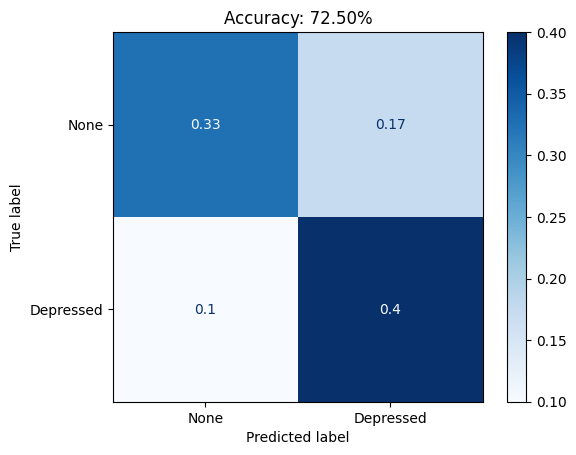

In [55]:
# DISTILBERT
ConfusionMatrixDisplay(confusion_matrix(y_trues, y_preds, normalize = 'all'), display_labels = ["None", "Depressed"]).plot(cmap=plt.cm.Blues)
plt.title(f"Accuracy: {balanced_accuracy_score(y_trues, y_preds)*100:.2f}%")

In [ ]:
!pip install transformers-interpret -q

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)
word_attributions = cls_explainer(dataset['test'][-3]['text'][:512])
cls_explainer.visualize("distilbert_viz.html")